# Extracting tabular data from PDF files

I decided to do a few posts on extracting data from PDF files. The series will go over extracting table-like data from PDF files specifically, and will show a few options for easily getting data into a format that's useful from an accounting perspective. Specifically, in this post, we'll look at tabular data that is mostly structured, and is computer generated. The only time you would want to be extracting data from a PDF file is when you cannot obtain the data in another format. If you **can** get any other format, such as CSV, tab-delimited, excel, etc then you should get that format instead and import with several much easier methods. The PDF parsing is not very easy, but at least with Python it becomes a lot easier than it otherwise would be.

There are basically two ways to use pdfplumber to extract text in a useful format from PDF files. One is using the extract_table or extract_tables methods, which finds and extracts tables as long as they are formatted easily enough for the code to understand where the parts of the table are. They can be tricky though, when words don't line up right. In those cases, the extract_text method might work better, combined with the parse library to parse the elements of each row as needed. We'll briefly show extract_text here, but stay tuned for a more in depth explanation and example of the extract_text in a future post.

## Let's get started!
First we will import the pandas and pdfplumber libraries. These do not come with standard python, and will need to be installed using pip, by typing ```pip install pandas pdfplumber``` within the command prompt. 

*Note: The recommended way to write programs and use pip install is within a virtual environment, rather than within base Python, but let's save that for a later lesson.*

## Import needed libraries

In [1]:
import pandas as pd
import numpy as np
import pdfplumber

## AR Aging Report - PDF to Python

In this example, we are using a PDF sample AR aging report I found [on this webpage](https://www.cwcsoftware.com/webhelp/Reports/HIDD_REP_AR2.htm) (it's the second link, which can be accessed [here](http://www.cwcsoftware.com/webhelp/Reports/Samples1010/ARbyCustDetailCompany.pdf)). We'll use pdfplumber to pull in the table and then use Pandas to convert the data, foot it, and perform a simple aging analysis.  

In [2]:
# Set the location of the pdf file
pdf_file = 'data/ARbyCustDetailCompany.pdf'

## Load the file in pdfplumber
Let's load the file, then see what the text looks like in the first group of rows

In [3]:
with pdfplumber.open(pdf_file) as pdf:
    first_page = pdf.pages[0]
    rows = first_page.extract_text().split('\n')
rows[:10]

['QF 1.100 (Build 1010) CWC Software, Inc. Page:    1',
 'Batch: 181 Test Mode Accounts Receivable Report Detailed by Company 03/14/16, 11:23:32',
 'Sorted by Customer',
 'Order Invoice Amount Payment Not',
 'Name/Company Telephone Publication Number Date Qty Paid Date Invoiced Current 31-60 61-90 Over 90 ST',
 'Barrow, Mr. Clyde AIC 2968 02/25/16    1      0.00      0.00    240.00      0.00      0.00      0.00 A',
 'Brown, Ms. Ida QWKFIL 2301 02/05/16    1     75.00 02/05/16      0.00      0.00     45.00      0.00      0.00 A',
 'Bush, Mr. George W. AIC 3086    1      0.00    216.00      0.00      0.00      0.00      0.00 A',
 'QWKFIL 3075    1      0.00    108.00      0.00      0.00      0.00      0.00 A',
 '     0.00    324.00      0.00      0.00      0.00      0.00']

### Let's view the image, checking to see how it has identified the various word in the page
Here we are converting the PDF to an image with outlines on each word, so we can tell what pdfplumber is considering "words". This will be useful for our next step, which will be to use words on the page to identify the edges of the table we want to crop.

*Note - you will need to install two libraries to get the image creation working with pdfplumber: ImageMagick (must be version 6.9 or earlier) and Ghostscript.*

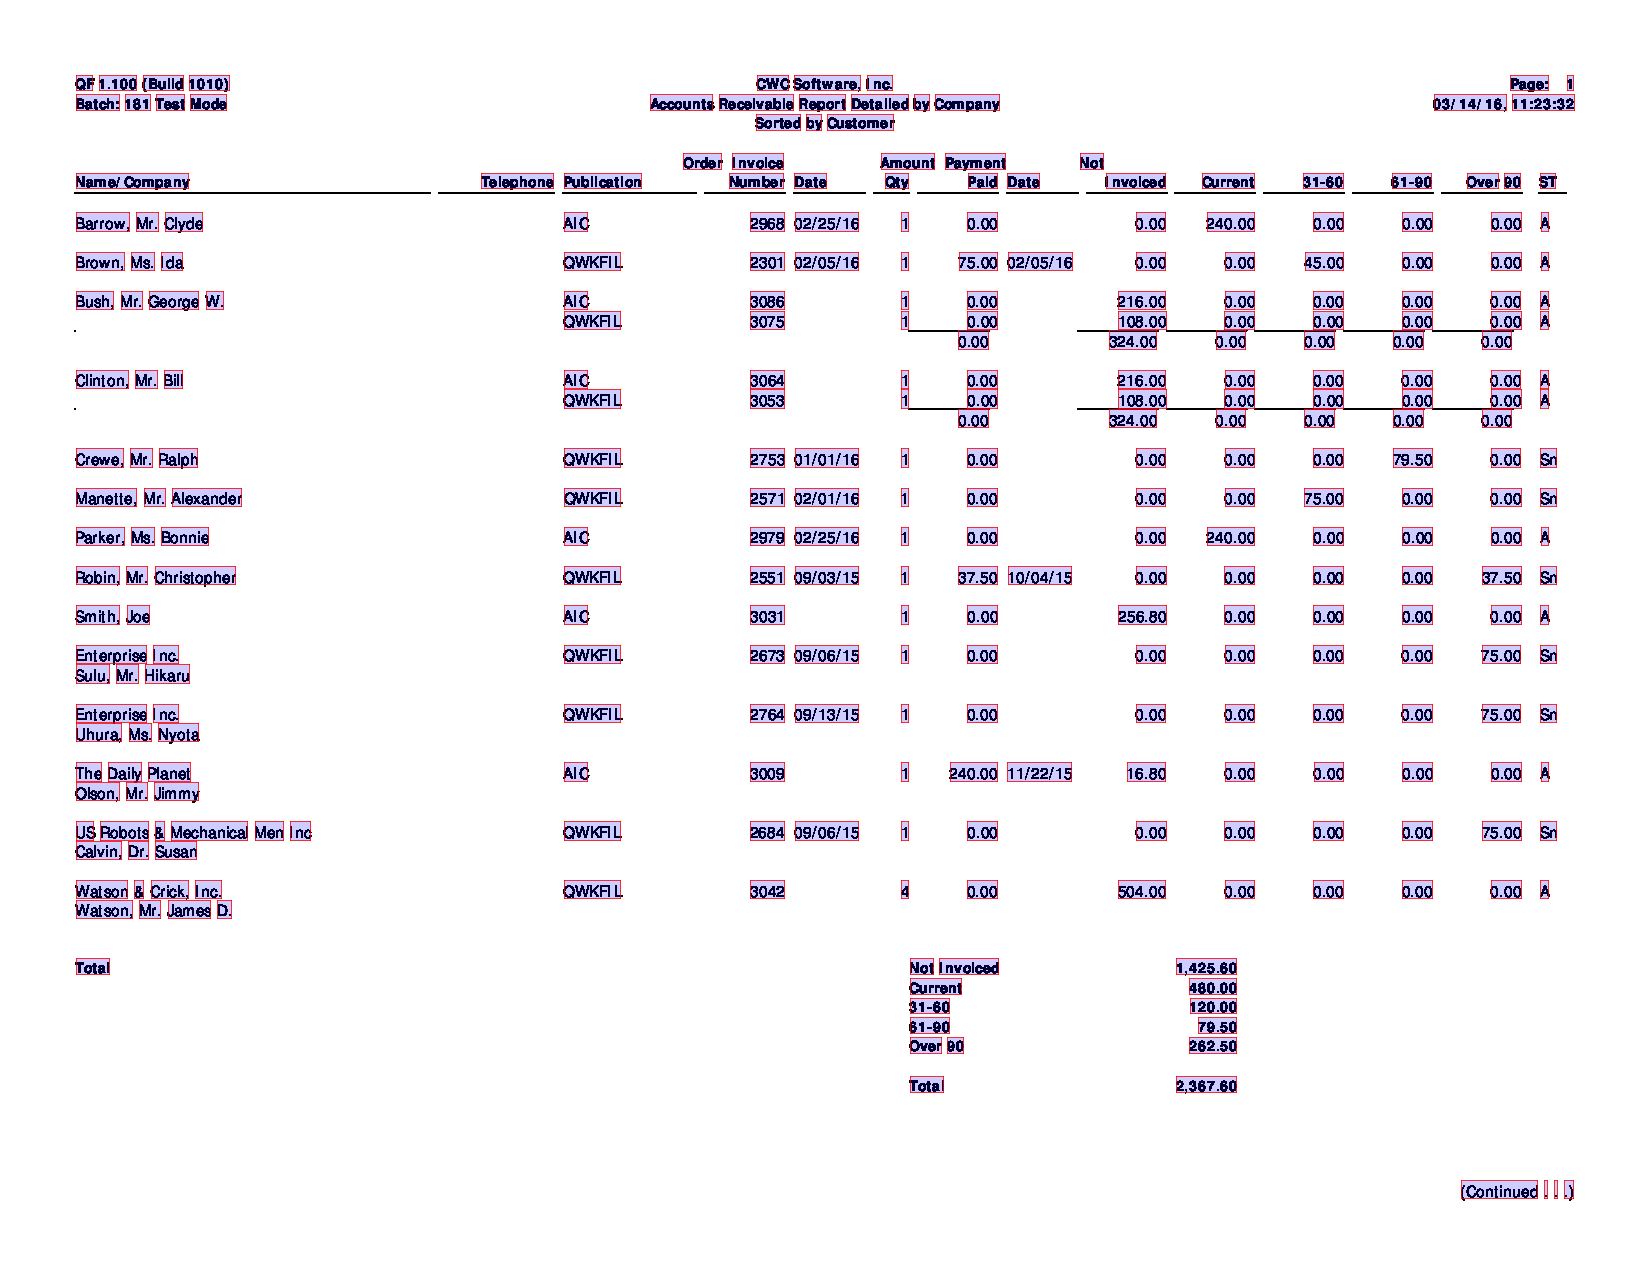

In [4]:
first_page.to_image(resolution=150).outline_words()

This looks like the right data, but because of the varying and inconsistent layout of each row, for this PDF, the extract_table should be easier than parsing it manually. The extract_table works best if you crop the PDF to just the table, so we will do that next.

### Crop the Main Table
We will crop the table by identifying the locations of various corner text pieces to use to build a box around the table we want to grab.

In [5]:
with pdfplumber.open(pdf_file) as pdf:
    first_page = pdf.pages[0]
    rows = first_page.extract_words()

for row in rows:
    if row['text'] == 'Name/Company':
        x0 = row['x0']
        top = row['top']
    if row['text'] == 'Watson':
        bottom = row['bottom']
    if row['text'] == 'ST':
        x1 = row['x1']

box = (x0, top, x1, bottom)
box

(Decimal('36.001'), Decimal('82.605'), Decimal('747.265'), Decimal('431.987'))

In [6]:
# Now we can crop the page starting with Name/Company for our upper and left bound, to right of 'ST' and bottom of "Watson"
with pdfplumber.open(pdf_file) as pdf:
    first_page = pdf.pages[0]
    page = first_page.crop(bbox=(box))  # (x0, top, x1, bottom)
    table = page.extract_table(table_settings={
        "vertical_strategy": "text",
        "horizontal_strategy": "text",
    })

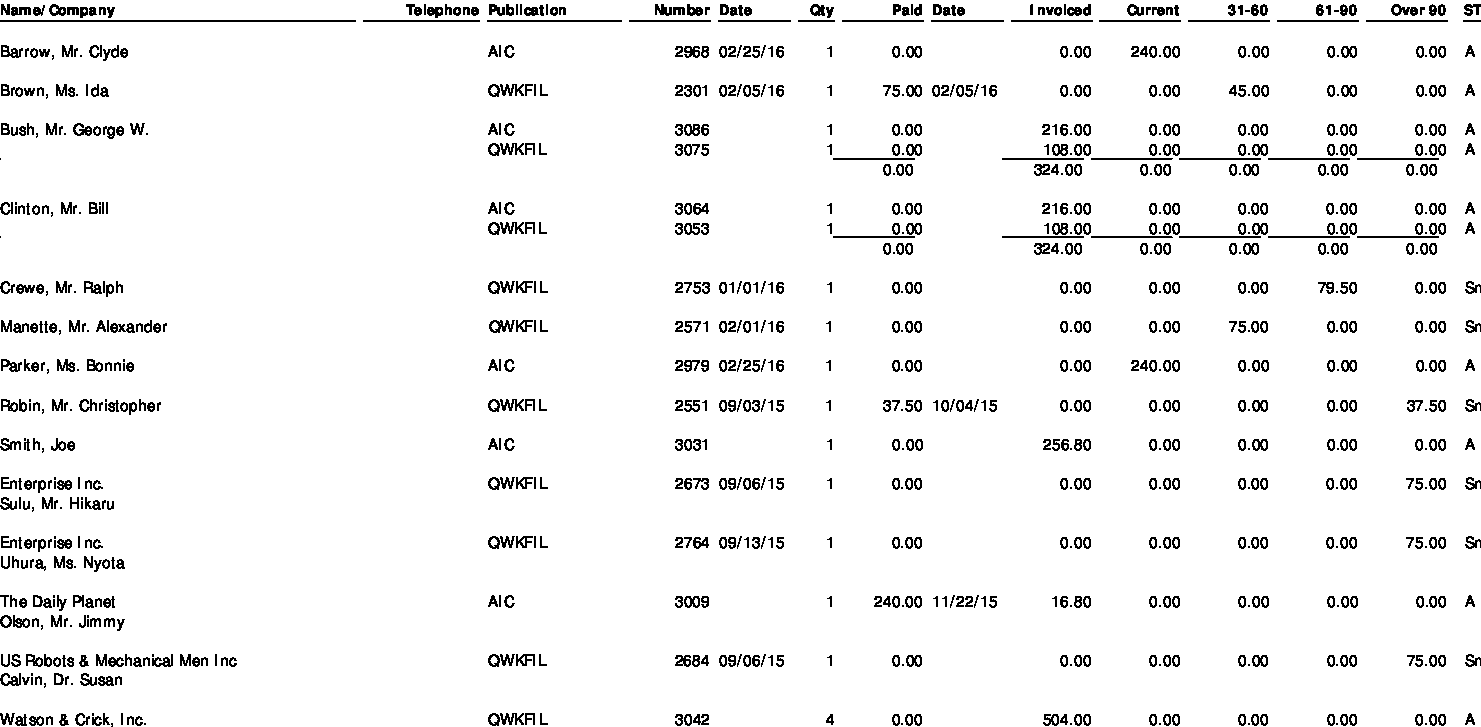

In [7]:
# Let's take a look at the cropped table
page.to_image(resolution=150)

In [8]:
# Ok- let's see how this is looking data-wise
for row in table[:8]:
    print(row)

['Name/Company Telephone', 'Publication', 'Number', 'Date', 'Qty', 'Paid', 'Date', 'Invoiced', 'Current', '31-60', '61-90 Ov', 'er 90', 'ST']
['', '', '', '', '', '', '', '', '', '', '', '', '']
['Barrow, Mr. Clyde', 'AIC', '2968', '02/25/16', '1', '0.00', '', '0.00', '240.00', '0.00', '0.00', '0.00', 'A']
['', '', '', '', '', '', '', '', '', '', '', '', '']
['Brown, Ms. Ida', 'QWKFIL', '2301', '02/05/16', '1', '75.00', '02/05/16', '0.00', '0.00', '45.00', '0.00', '0.00', 'A']
['', '', '', '', '', '', '', '', '', '', '', '', '']
['Bush, Mr. George W.', 'AIC', '3086', '', '1', '0.00', '', '216.00', '0.00', '0.00', '0.00', '0.00', 'A']
['', 'QWKFIL', '3075', '', '1', '0.00', '', '108.00', '0.00', '0.00', '0.00', '0.00', 'A']


### Nice progress, but a few issues 
1. Blank rows   
```['', '', ''...]```
2. Funky columns    
```'61-90 Ov', 'er 90'```
3. Because of how we cut off the table, we're missing part of some of the column names such as 'Not Invoiced' rather than 'Invoiced'

In [9]:
# Fis the blank rows by including only those rows that do not all equal blank strings
table = [row for row in table if ''.join([str(i) for i in row]) != '']

## Load into a dataframe and view the first five rows

In [10]:
df = pd.DataFrame(table)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Name/Company Telephone,Publication,Number,Date,Qty,Paid,Date,Invoiced,Current,31-60,61-90 Ov,er 90,ST
1,"Barrow, Mr. Clyde",AIC,2968,02/25/16,1,0.00,,0.00,240.00,0.00,0.00,0.00,A
2,"Brown, Ms. Ida",QWKFIL,2301,02/05/16,1,75.00,02/05/16,0.00,0.00,45.00,0.00,0.00,A
3,"Bush, Mr. George W.",AIC,3086,,1,0.00,,216.00,0.00,0.00,0.00,0.00,A
4,,QWKFIL,3075,,1,0.00,,108.00,0.00,0.00,0.00,0.00,A


### Two new issues
1. Column names are just numbers
2. Record 4 is missing the name. We can't pivot unless all fields are filled out, so we need to fill down here.

In [11]:
# Update the column names
columns = df.iloc[0]
columns

0     Name/Company Telephone
1                Publication
2                     Number
3                       Date
4                        Qty
5                       Paid
6                       Date
7                   Invoiced
8                    Current
9                      31-60
10                  61-90 Ov
11                     er 90
12                        ST
Name: 0, dtype: object

In [12]:
columns[7], columns[10], columns[11] = 'Not Invoiced', '61-90', 'Over 90'

### Set the column names and drop the first row.

In [13]:
df.columns = columns
df = df.drop(0)
df.head()

,Name/Company Telephone,Publication,Number,Date,Qty,Paid,Date,Not Invoiced,Current,31-60,61-90,Over 90,ST
1,"Barrow, Mr. Clyde",AIC,2968,02/25/16,1,0.00,,0.00,240.00,0.00,0.00,0.00,A
2,"Brown, Ms. Ida",QWKFIL,2301,02/05/16,1,75.00,02/05/16,0.00,0.00,45.00,0.00,0.00,A
3,"Bush, Mr. George W.",AIC,3086,,1,0.00,,216.00,0.00,0.00,0.00,0.00,A
4,,QWKFIL,3075,,1,0.00,,108.00,0.00,0.00,0.00,0.00,A
5,,,,,,0.00,,324.00,0.00,0.00,0.00,0.00,


### Before we move on....
We should check the data types - the columns with numbers should be 'float' or 'int', and if they are not we will need to convert them. This will cause problems if we do any math, which we need to do, because strings behave very differently than numbers. See example below

In [14]:
print('1' + '5')  # formatted as string
print(1 + 5)      # formatted as ints

15
6


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 1 to 24
Data columns (total 13 columns):
Name/Company Telephone    24 non-null object
Publication               24 non-null object
Number                    24 non-null object
Date                      21 non-null object
Qty                       24 non-null object
Paid                      24 non-null object
Date                      18 non-null object
Not Invoiced              24 non-null object
Current                   24 non-null object
31-60                     24 non-null object
61-90                     24 non-null object
Over 90                   24 non-null object
ST                        24 non-null object
dtypes: object(13)
memory usage: 2.6+ KB


### Looks like we need to fix this
It looks like the numbers are comign in as "object", which means they'll be treated as strings. No good. We can fix using a function that converts to float.

In [16]:
def convert_to_float(num):
    try:
        return float(num.replace(',',''))
    except:
        return 0

In [17]:
for col in ['Not Invoiced', 'Current', '31-60', '61-90', 'Over 90']:
    df[col] = df[col].map(convert_to_float)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 1 to 24
Data columns (total 13 columns):
Name/Company Telephone    24 non-null object
Publication               24 non-null object
Number                    24 non-null object
Date                      21 non-null object
Qty                       24 non-null object
Paid                      24 non-null object
Date                      18 non-null object
Not Invoiced              24 non-null float64
Current                   24 non-null float64
31-60                     24 non-null float64
61-90                     24 non-null float64
Over 90                   24 non-null float64
ST                        24 non-null object
dtypes: float64(5), object(8)
memory usage: 2.6+ KB


### Good! Now, let's only include columns we need

In [18]:
df = df[['Name/Company Telephone', 'Not Invoiced', 'Current', '31-60', '61-90', 'Over 90']]
df

,Name/Company Telephone,Not Invoiced,Current,31-60,61-90,Over 90
1,"Barrow, Mr. Clyde",0.0,240.0,0.0,0.0,0.0
2,"Brown, Ms. Ida",0.0,0.0,45.0,0.0,0.0
3,"Bush, Mr. George W.",216.0,0.0,0.0,0.0,0.0
4,,108.0,0.0,0.0,0.0,0.0
5,,324.0,0.0,0.0,0.0,0.0
6,"Clinton, Mr. Bill",216.0,0.0,0.0,0.0,0.0
7,,108.0,0.0,0.0,0.0,0.0
8,,324.0,0.0,0.0,0.0,0.0
9,"Crewe, Mr. Ralph",0.0,0.0,0.0,79.5,0.0
10,"Manette, Mr. Alexander",0.0,0.0,75.0,0.0,0.0


### Looking good! Let's drop-down the names to empty records so we can properly create a pivot table

In [19]:
df['Name/Company Telephone'] = df[['Name/Company Telephone']].replace('', np.nan).ffill()
df.head(8)

,Name/Company Telephone,Not Invoiced,Current,31-60,61-90,Over 90
1,"Barrow, Mr. Clyde",0.0,240.0,0.0,0.0,0.0
2,"Brown, Ms. Ida",0.0,0.0,45.0,0.0,0.0
3,"Bush, Mr. George W.",216.0,0.0,0.0,0.0,0.0
4,"Bush, Mr. George W.",108.0,0.0,0.0,0.0,0.0
5,"Bush, Mr. George W.",324.0,0.0,0.0,0.0,0.0
6,"Clinton, Mr. Bill",216.0,0.0,0.0,0.0,0.0
7,"Clinton, Mr. Bill",108.0,0.0,0.0,0.0,0.0
8,"Clinton, Mr. Bill",324.0,0.0,0.0,0.0,0.0


### Let's look at a pivot table by sum of values on Name

In [20]:
pivot = df.pivot_table(index='Name/Company Telephone', aggfunc=sum)

In [21]:
pivot

,31-60,61-90,Current,Not Invoiced,Over 90
Name/Company Telephone,,,,,
"Barrow, Mr. Clyde",0.0,0.0,240.0,0.0,0.0
"Brown, Ms. Ida",45.0,0.0,0.0,0.0,0.0
"Bush, Mr. George W.",0.0,0.0,0.0,648.0,0.0
"Calvin, Dr. Susan",0.0,0.0,0.0,0.0,0.0
"Clinton, Mr. Bill",0.0,0.0,0.0,648.0,0.0
"Crewe, Mr. Ralph",0.0,79.5,0.0,0.0,0.0
Enterprise Inc.,0.0,0.0,0.0,0.0,150.0
"Manette, Mr. Alexander",75.0,0.0,0.0,0.0,0.0
"Olson, Mr. Jimmy",0.0,0.0,0.0,0.0,0.0


### The columns are out of order. No prob, let's feed in the correct order.

In [22]:
pivot = pivot[['Not Invoiced', 'Current', '31-60', '61-90', 'Over 90']]
pivot

,Not Invoiced,Current,31-60,61-90,Over 90
Name/Company Telephone,,,,,
"Barrow, Mr. Clyde",0.0,240.0,0.0,0.0,0.0
"Brown, Ms. Ida",0.0,0.0,45.0,0.0,0.0
"Bush, Mr. George W.",648.0,0.0,0.0,0.0,0.0
"Calvin, Dr. Susan",0.0,0.0,0.0,0.0,0.0
"Clinton, Mr. Bill",648.0,0.0,0.0,0.0,0.0
"Crewe, Mr. Ralph",0.0,0.0,0.0,79.5,0.0
Enterprise Inc.,0.0,0.0,0.0,0.0,150.0
"Manette, Mr. Alexander",0.0,0.0,75.0,0.0,0.0
"Olson, Mr. Jimmy",0.0,0.0,0.0,0.0,0.0


### Now we have a DataFrame that looks like an AR Aging! Let's check the totals against the report.

In [23]:
with pdfplumber.open(pdf_file) as pdf:
    first_page = pdf.pages[0]
    text = first_page.extract_text().split('\n')
    totals_str = text[-7:-1]

In [24]:
totals = {}
for line in totals_str:
    line = line.replace('Total Not Invoiced', 'Not Invoiced')
    *key, val = line.split()
    totals[' '.join(key)] = convert_to_float(val)
totals

{'Not Invoiced': 1425.6,
 'Current': 480.0,
 '31-60': 120.0,
 '61-90': 79.5,
 'Over 90': 262.5,
 'Total': 2367.6}

In [25]:
# Totals from report for validation purposes:
def validate_totals(pivot):

    pivot_dict = dict(zip(pivot.sum().index, pivot.sum().values))
    pivot_dict['Total'] = pivot.sum().sum()

    print('Reconciliation:')
    for key, val in totals.items():
        calc_val = pivot_dict[key]
        dif = val - calc_val
        print(f'{key.ljust(12)} - expected value of {val}, actual of {calc_val}, difference is {dif}')
        
validate_totals(pivot)

Reconciliation:
Not Invoiced - expected value of 1425.6, actual of 2073.6, difference is -648.0
Current      - expected value of 480.0, actual of 480.0, difference is 0.0
31-60        - expected value of 120.0, actual of 120.0, difference is 0.0
61-90        - expected value of 79.5, actual of 79.5, difference is 0.0
Over 90      - expected value of 262.5, actual of 262.5, difference is 0.0
Total        - expected value of 2367.6, actual of 3015.6, difference is -648.0


### Something is awry!
After some investigation, it looks like we included subtotals lines inadvertantly, so we'll need to exclude those. There are several ways to fix, but easiest to me is use the Qty column early on, if it's blank then we should drop the row.

In [26]:
df = pd.DataFrame(table)
columns = df.iloc[0]
columns[7], columns[10], columns[11] = 'Not Invoiced', '61-90', 'Over 90'
df.columns = columns
df = df.drop(0)

def convert_to_float(num):
    try:
        return float(num.replace(',',''))
    except:
        return 0

for col in ['Not Invoiced', 'Current', '31-60', '61-90', 'Over 90']:
    df[col] = df[col].map(convert_to_float)

df = df[['Name/Company Telephone', 'Qty', 'Not Invoiced', 'Current', '31-60', '61-90', 'Over 90']]

df['Name/Company Telephone'] = df[['Name/Company Telephone']].replace('', np.nan).ffill()

# Remove columns without Qty
df = df[df['Qty'] != '']

pivot = df.pivot_table(index='Name/Company Telephone', aggfunc=sum)

pivot = pivot[['Not Invoiced', 'Current', '31-60', '61-90', 'Over 90']]

validate_totals(pivot)

Reconciliation:
Not Invoiced - expected value of 1425.6, actual of 1425.6, difference is 0.0
Current      - expected value of 480.0, actual of 480.0, difference is 0.0
31-60        - expected value of 120.0, actual of 120.0, difference is 0.0
61-90        - expected value of 79.5, actual of 79.5, difference is 0.0
Over 90      - expected value of 262.5, actual of 262.5, difference is 0.0
Total        - expected value of 2367.6, actual of 2367.6, difference is 0.0


### Woohoo! Differences are all zero! Now that we've reconciled the AR Aging, we can look at what the actual aging shows.

In [27]:
pivot['Total']= pivot.sum(axis=1)

In [28]:
pivot.loc['Total'] = pivot.sum()

In [29]:
pivot.loc['Perc'] = round(pivot.loc['Total'] / pivot.loc['Total'].sum() * 200, 2)

In [30]:
pivot

,Not Invoiced,Current,31-60,61-90,Over 90,Total
Name/Company Telephone,,,,,,
"Barrow, Mr. Clyde",0.00,240.00,0.00,0.00,0.00,240.0
"Brown, Ms. Ida",0.00,0.00,45.00,0.00,0.00,45.0
"Bush, Mr. George W.",324.00,0.00,0.00,0.00,0.00,324.0
"Clinton, Mr. Bill",324.00,0.00,0.00,0.00,0.00,324.0
"Crewe, Mr. Ralph",0.00,0.00,0.00,79.50,0.00,79.5
Enterprise Inc.,0.00,0.00,0.00,0.00,150.00,150.0
"Manette, Mr. Alexander",0.00,0.00,75.00,0.00,0.00,75.0
"Parker, Ms. Bonnie",0.00,240.00,0.00,0.00,0.00,240.0
"Robin, Mr. Christopher",0.00,0.00,0.00,0.00,37.50,37.5


## What now?
From here, you can do a few things.

1. You can export this dataframe to excel or csv and perform any standard tests or calculations you would perform on a regular spreadsheet version of an AR aging, such as exploring an unusual higher percentage of older AR, any negative AR, related parties, etc. 
2. You can automate this process, assuming the data will always be in the same format.

For now... let's see what a csv output looks like...

In [31]:
pivot.to_csv('test.csv')

In [32]:
with open('test.csv') as f:
    print(f.read())

Name/Company Telephone,Not Invoiced,Current,31-60,61-90,Over 90,Total
"Barrow, Mr. Clyde",0.0,240.0,0.0,0.0,0.0,240.0
"Brown, Ms. Ida",0.0,0.0,45.0,0.0,0.0,45.0
"Bush, Mr. George W.",324.0,0.0,0.0,0.0,0.0,324.0
"Clinton, Mr. Bill",324.0,0.0,0.0,0.0,0.0,324.0
"Crewe, Mr. Ralph",0.0,0.0,0.0,79.5,0.0,79.5
Enterprise Inc.,0.0,0.0,0.0,0.0,150.0,150.0
"Manette, Mr. Alexander",0.0,0.0,75.0,0.0,0.0,75.0
"Parker, Ms. Bonnie",0.0,240.0,0.0,0.0,0.0,240.0
"Robin, Mr. Christopher",0.0,0.0,0.0,0.0,37.5,37.5
"Smith, Joe",256.8,0.0,0.0,0.0,0.0,256.8
The Daily Planet,16.8,0.0,0.0,0.0,0.0,16.8
US Robots & Mechanical Men Inc,0.0,0.0,0.0,0.0,75.0,75.0
"Watson & Crick, Inc.
Watson, Mr. James D.",504.0,0.0,0.0,0.0,0.0,504.0
Total,1425.6,480.0,120.0,79.5,262.5,2367.6
Perc,60.21,20.27,5.07,3.36,11.09,100.0



Stay tuned for the next one, and as always let me know if you have any questions or issues understanding what I've done here!

-Dan